## 1. Import Libraries

In [22]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Load All Datasets

In [23]:
# Load all datasets
data_path = '../data/raw/'

beneficiary_df = pd.read_csv(data_path + 'Train_Beneficiarydata-1542865627584.csv')
inpatient_df = pd.read_csv(data_path + 'Train_Inpatientdata-1542865627584.csv')
outpatient_df = pd.read_csv(data_path + 'Train_Outpatientdata-1542865627584.csv')
labels_df = pd.read_csv(data_path + 'Train-1542865627584.csv')
test_inpatient_df = pd.read_csv(data_path + 'Test_Inpatientdata-1542969243754.csv')
test_outpatient_df = pd.read_csv(data_path + 'Test_Outpatientdata-1542969243754.csv')
test_labels_df = pd.read_csv(data_path + 'Test-1542969243754.csv')

## 3. Cleaning Beneficiary.csv


In [24]:
# Load beneficiary data
import os

Train_Beneficiarydata = pd.read_csv("../data/raw/Train_Beneficiarydata-1542865627584.csv")
Test_Beneficiarydata  = pd.read_csv("../data/raw/Test_Beneficiarydata-1542969243754.csv")

print(f"Train shape: {Train_Beneficiarydata.shape}")
print(f"Test shape: {Test_Beneficiarydata.shape}")

binary_replace_cols = [
    'Gender','Race','ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease',
    'ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis',
    'ChronicCond_stroke'
]

Train_Beneficiarydata[binary_replace_cols] = Train_Beneficiarydata[binary_replace_cols].replace(2, 0)
Test_Beneficiarydata[binary_replace_cols]  = Test_Beneficiarydata[binary_replace_cols].replace(2, 0)

# Renal Disease: convert 'Y' to 1
Train_Beneficiarydata['RenalDiseaseIndicator'] = Train_Beneficiarydata['RenalDiseaseIndicator'].replace({'Y':1})
Test_Beneficiarydata['RenalDiseaseIndicator']  = Test_Beneficiarydata['RenalDiseaseIndicator'].replace({'Y':1})

# Convert dates
Train_Beneficiarydata['DOB'] = pd.to_datetime(Train_Beneficiarydata['DOB'], errors='coerce')
Train_Beneficiarydata['DOD'] = pd.to_datetime(Train_Beneficiarydata['DOD'], errors='coerce')
Test_Beneficiarydata['DOB'] = pd.to_datetime(Test_Beneficiarydata['DOB'], errors='coerce')
Test_Beneficiarydata['DOD'] = pd.to_datetime(Test_Beneficiarydata['DOD'], errors='coerce')

Train_Beneficiarydata['Age'] = (Train_Beneficiarydata['DOD']-Train_Beneficiarydata['DOB']).dt.days // 365
Test_Beneficiarydata['Age'] = (Test_Beneficiarydata['DOD']-Test_Beneficiarydata['DOB']).dt.days // 365

# Fill alive patients with dataset's  (last death was 1/12/2009) - DOB 
Test_Beneficiarydata['Age']=Test_Beneficiarydata['Age'].fillna((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - Test_Beneficiarydata['DOB']).dt.days // 365)
Train_Beneficiarydata['Age']=Train_Beneficiarydata['Age'].fillna((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - Train_Beneficiarydata['DOB']).dt.days // 365)

Train_Beneficiarydata["IsDeceased"] = Train_Beneficiarydata["DOD"].notna().astype(int)
Test_Beneficiarydata["IsDeceased"]  = Test_Beneficiarydata["DOD"].notna().astype(int)

# Drop raw date columns
Train_Beneficiarydata = Train_Beneficiarydata.drop(columns=["DOB","DOD"]) 
Test_Beneficiarydata  = Test_Beneficiarydata.drop(columns=["DOB","DOD"]) 

# Save cleaned data
os.makedirs("../data/processed", exist_ok=True)
Train_Beneficiarydata.to_csv("../data/processed/Train_Beneficiarydata_cleaned.csv", index=False)
Test_Beneficiarydata.to_csv("../data/processed/Test_Beneficiarydata_cleaned.csv", index=False)

print("Cleaned beneficiary data saved to ../data/processed/")
print(f"Train cleaned shape: {Train_Beneficiarydata.shape}")
print(f"Test cleaned shape: {Test_Beneficiarydata.shape}")
print(Train_Beneficiarydata.head(5))

Train shape: (138556, 25)
Test shape: (63968, 25)
Cleaned beneficiary data saved to ../data/processed/
Train cleaned shape: (138556, 25)
Test cleaned shape: (63968, 25)
      BeneID  Gender  Race RenalDiseaseIndicator  State  County  \
0  BENE11001       1     1                     0     39     230   
1  BENE11002       0     1                     0     39     280   
2  BENE11003       1     1                     0     52     590   
3  BENE11004       1     1                     0     39     270   
4  BENE11005       1     1                     0     24     680   

   NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0                   12                   12                      1   
1                   12                   12                      0   
2                   12                   12                      1   
3                   12                   12                      1   
4                   12                   12                      0   

   Chro

## 4. Data Quality Assessment - Inpatient Data

In [25]:
print("\nShape:", inpatient_df.shape)
print("\nColumn Information:")
print(inpatient_df.info())

print("\nMissing Values:")
missing = inpatient_df.isnull().sum()
missing_pct = (missing / len(inpatient_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

print("\nDuplicates:", inpatient_df.duplicated().sum())
print("\nFirst 5 rows:")
inpatient_df.head()


Shape: (40474, 30)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 1

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.00,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.00,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.00,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.00,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.00,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.00,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.00,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.00,NaN,NaN,NaN,NaN,NaN


## 5. Examine Dataset Relationships and Join Keys

In [26]:
print("\nKEY IDENTIFIERS:")
print(f"\n1. BeneID (Patient Identifier):")
print(f"   - Unique beneficiaries: {beneficiary_df['BeneID'].nunique():,}")
print(f"   - In inpatient claims: {inpatient_df['BeneID'].nunique():,}")
print(f"   - In outpatient claims: {outpatient_df['BeneID'].nunique():,}")


print(f"\n2. Provider (Healthcare Provider Identifier):")
print(f"   - Labeled providers: {labels_df['Provider'].nunique():,}")
print(f"   - Providers in inpatient: {inpatient_df['Provider'].nunique():,}")
print(f"   - Providers in outpatient: {outpatient_df['Provider'].nunique():,}")


print(f"\n3. ClaimID (Claim Identifier):")
print(f"   - Inpatient claims: {inpatient_df['ClaimID'].nunique():,}")
print(f"   - Outpatient claims: {outpatient_df['ClaimID'].nunique():,}")


KEY IDENTIFIERS:

1. BeneID (Patient Identifier):
   - Unique beneficiaries: 138,556
   - In inpatient claims: 31,289
   - In outpatient claims: 133,980

2. Provider (Healthcare Provider Identifier):
   - Labeled providers: 5,410
   - Providers in inpatient: 2,092
   - Providers in outpatient: 5,012

3. ClaimID (Claim Identifier):
   - Inpatient claims: 40,474
   - Outpatient claims: 517,737


## 6. Target Variable Analysis


Fraud Distribution:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Percentage:
PotentialFraud
No    90.65
Yes    9.35
Name: proportion, dtype: float64

Class Imbalance Ratio: 9.69:1 (Non-fraud:Fraud)


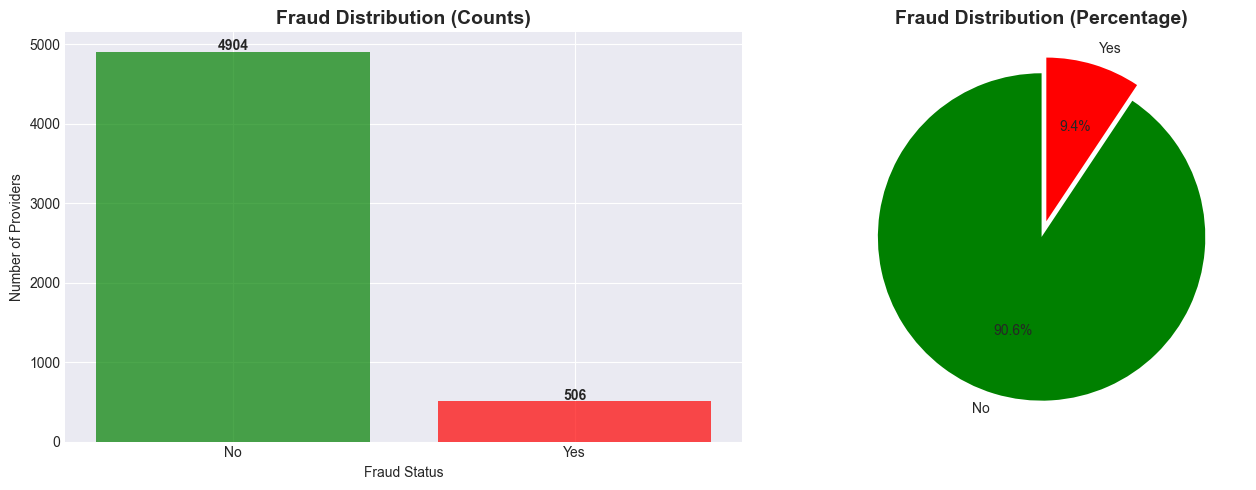

In [27]:
fraud_counts = labels_df['PotentialFraud'].value_counts()
fraud_pct = labels_df['PotentialFraud'].value_counts(normalize=True) * 100

print("\nFraud Distribution:")
print(fraud_counts)
print("\nPercentage:")
print(fraud_pct)
print(f"\nClass Imbalance Ratio: {fraud_counts['No'] / fraud_counts['Yes']:.2f}:1 (Non-fraud:Fraud)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(fraud_counts.index, fraud_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Fraud Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Number of Providers')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['green', 'red']
axes[1].pie(fraud_pct.values, labels=fraud_pct.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
# Convert target to binary
labels_df['Fraud'] = (labels_df['PotentialFraud'] == 'Yes').astype(int)


## 7. Date Feature Engineering

In [28]:
# Convert dates for inpatient
date_cols_inpatient = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols_inpatient:
    if col in inpatient_df.columns:
        inpatient_df[col] = pd.to_datetime(inpatient_df[col], errors='coerce')
    
for col in date_cols_inpatient:
    if col in test_inpatient_df.columns:
        test_inpatient_df[col] = pd.to_datetime(test_inpatient_df[col], errors='coerce')

# Create temporal features
inpatient_df['ClaimDuration'] = (inpatient_df['ClaimEndDt'] - inpatient_df['ClaimStartDt']).dt.days
inpatient_df['AdmissionDuration'] = (inpatient_df['DischargeDt'] - inpatient_df['AdmissionDt']).dt.days
inpatient_df['ClaimMonth'] = inpatient_df['ClaimStartDt'].dt.month
inpatient_df['ClaimYear'] = inpatient_df['ClaimStartDt'].dt.year
inpatient_df['ClaimDayOfWeek'] = inpatient_df['ClaimStartDt'].dt.dayofweek

test_inpatient_df['ClaimDuration'] = (test_inpatient_df['ClaimEndDt'] - test_inpatient_df['ClaimStartDt']).dt.days
test_inpatient_df['AdmissionDuration'] = (test_inpatient_df['DischargeDt'] - test_inpatient_df['AdmissionDt']).dt.days
test_inpatient_df['ClaimMonth'] = test_inpatient_df['ClaimStartDt'].dt.month
test_inpatient_df['ClaimYear'] = test_inpatient_df['ClaimStartDt'].dt.year
test_inpatient_df['ClaimDayOfWeek'] = test_inpatient_df['ClaimStartDt'].dt.dayofweek

print("Temporal features created")
print("\nDate Range:")
print(f"Claim Start: {inpatient_df['ClaimStartDt'].min()} to {inpatient_df['ClaimStartDt'].max()}")
print(f"\nClaim Duration Statistics:")
print(inpatient_df['ClaimDuration'].describe())
print(f"\nAdmission Duration Statistics:")
print(inpatient_df['AdmissionDuration'].describe())

Temporal features created

Date Range:
Claim Start: 2008-11-27 00:00:00 to 2009-12-31 00:00:00

Claim Duration Statistics:
count   40474.00
mean        5.66
std         5.63
min         0.00
25%         2.00
50%         4.00
75%         7.00
max        36.00
Name: ClaimDuration, dtype: float64

Admission Duration Statistics:
count   40474.00
mean        5.67
std         5.64
min         0.00
25%         2.00
50%         4.00
75%         7.00
max        35.00
Name: AdmissionDuration, dtype: float64


## 8. Provider-Level Aggregation - Inpatient Claims

In [29]:
print("Creating provider-level features from inpatient claims...")

# Aggregate inpatient data by provider
provider_inpatient = inpatient_df.groupby('Provider').agg({
    'ClaimID': 'count',  # Number of claims
    'BeneID': 'nunique',  # Unique patients
    'InscClaimAmtReimbursed': ['mean', 'sum', 'max', 'std', 'median'],
    'DeductibleAmtPaid': ['mean', 'sum'],
    'ClaimDuration': ['mean', 'sum', 'max', 'std'],
    'AdmissionDuration': ['mean', 'sum', 'max', 'std'],
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).reset_index()

test_provider_inpatient = test_inpatient_df.groupby('Provider').agg({
    'ClaimID': 'count',  # Number of claims
    'BeneID': 'nunique',  # Unique patients
    'InscClaimAmtReimbursed': ['mean', 'sum', 'max', 'std', 'median'],
    'DeductibleAmtPaid': ['mean', 'sum'],
    'ClaimDuration': ['mean', 'sum', 'max', 'std'],
    'AdmissionDuration': ['mean', 'sum', 'max', 'std'],
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).reset_index()

# Flatten column names
provider_inpatient.columns = ['Provider', 
    'IP_NumClaims', 'IP_NumBeneficiaries',
    'IP_AvgReimbursement', 'IP_TotalReimbursement', 'IP_MaxReimbursement', 'IP_StdReimbursement', 'IP_MedianReimbursement',
    'IP_AvgDeductible', 'IP_TotalDeductible',
    'IP_AvgClaimDuration', 'IP_TotalClaimDuration', 'IP_MaxClaimDuration', 'IP_StdClaimDuration',
    'IP_AvgAdmissionDuration', 'IP_TotalAdmissionDuration', 'IP_MaxAdmissionDuration', 'IP_StdAdmissionDuration',
    'IP_NumAttendingPhysicians', 'IP_NumOperatingPhysicians', 'IP_NumOtherPhysicians'
]

test_provider_inpatient.columns = ['Provider', 
    'IP_NumClaims', 'IP_NumBeneficiaries',
    'IP_AvgReimbursement', 'IP_TotalReimbursement', 'IP_MaxReimbursement', 'IP_StdReimbursement', 'IP_MedianReimbursement',
    'IP_AvgDeductible', 'IP_TotalDeductible',
    'IP_AvgClaimDuration', 'IP_TotalClaimDuration', 'IP_MaxClaimDuration', 'IP_StdClaimDuration',
    'IP_AvgAdmissionDuration', 'IP_TotalAdmissionDuration', 'IP_MaxAdmissionDuration', 'IP_StdAdmissionDuration',
    'IP_NumAttendingPhysicians', 'IP_NumOperatingPhysicians', 'IP_NumOtherPhysicians'
]

# Fill missing std values (occurs when provider has only 1 claim)
provider_inpatient['IP_StdReimbursement'] = provider_inpatient['IP_StdReimbursement'].fillna(0)
provider_inpatient['IP_StdClaimDuration'] = provider_inpatient['IP_StdClaimDuration'].fillna(0)
provider_inpatient['IP_StdAdmissionDuration'] = provider_inpatient['IP_StdAdmissionDuration'].fillna(0)

test_provider_inpatient['IP_StdReimbursement'] = test_provider_inpatient['IP_StdReimbursement'].fillna(0)
test_provider_inpatient['IP_StdClaimDuration'] = test_provider_inpatient['IP_StdClaimDuration'].fillna(0)
test_provider_inpatient['IP_StdAdmissionDuration'] = test_provider_inpatient['IP_StdAdmissionDuration'].fillna(0)

# Derived features
provider_inpatient['IP_ClaimsPerBeneficiary'] = provider_inpatient['IP_NumClaims'] / provider_inpatient['IP_NumBeneficiaries']
provider_inpatient['IP_ReimbursementPerDay'] = provider_inpatient['IP_TotalReimbursement'] / provider_inpatient['IP_TotalAdmissionDuration'].replace(0, np.nan)
provider_inpatient['IP_ReimbursementPerBeneficiary'] = provider_inpatient['IP_TotalReimbursement'] / provider_inpatient['IP_NumBeneficiaries']
provider_inpatient['IP_TotalPhysicians'] = provider_inpatient['IP_NumAttendingPhysicians'] + provider_inpatient['IP_NumOperatingPhysicians'] + provider_inpatient['IP_NumOtherPhysicians']

test_provider_inpatient['IP_ClaimsPerBeneficiary'] = test_provider_inpatient['IP_NumClaims'] / test_provider_inpatient['IP_NumBeneficiaries']
test_provider_inpatient['IP_ReimbursementPerDay'] = test_provider_inpatient['IP_TotalReimbursement'] / test_provider_inpatient['IP_TotalAdmissionDuration'].replace(0, np.nan)
test_provider_inpatient['IP_ReimbursementPerBeneficiary'] = test_provider_inpatient['IP_TotalReimbursement'] / test_provider_inpatient['IP_NumBeneficiaries']
test_provider_inpatient['IP_TotalPhysicians'] = test_provider_inpatient['IP_NumAttendingPhysicians'] + test_provider_inpatient['IP_NumOperatingPhysicians'] + test_provider_inpatient['IP_NumOtherPhysicians']

print(f"Created provider-level inpatient features: {provider_inpatient.shape}")
provider_inpatient.head()

Creating provider-level features from inpatient claims...
Created provider-level inpatient features: (2092, 25)


,Provider,IP_NumClaims,IP_NumBeneficiaries,IP_AvgReimbursement,IP_TotalReimbursement,IP_MaxReimbursement,IP_StdReimbursement,IP_MedianReimbursement,IP_AvgDeductible,IP_TotalDeductible,IP_AvgClaimDuration,IP_TotalClaimDuration,IP_MaxClaimDuration,IP_StdClaimDuration,IP_AvgAdmissionDuration,IP_TotalAdmissionDuration,IP_MaxAdmissionDuration,IP_StdAdmissionDuration,IP_NumAttendingPhysicians,IP_NumOperatingPhysicians,IP_NumOtherPhysicians,IP_ClaimsPerBeneficiary,IP_ReimbursementPerDay,IP_ReimbursementPerBeneficiary,IP_TotalPhysicians
0,PRV51001,5,5,19400.00,97000,42000,18352.11,12000.00,1068.00,5340.00,5.00,25,14,5.39,5.00,25,14,5.39,4,2,1,1.00,3880.00,19400.00,7
1,PRV51003,62,53,9241.94,573000,57000,8513.61,7000.00,1068.00,66216.00,5.16,320,27,4.45,5.16,320,27,4.45,2,2,0,1.17,1790.62,10811.32,4
2,PRV51007,3,3,6333.33,19000,10000,3511.88,6000.00,1068.00,3204.00,5.33,16,7,1.53,5.33,16,7,1.53,2,1,0,1.00,1187.50,6333.33,3
3,PRV51008,2,2,12500.00,25000,21000,12020.82,12500.00,1068.00,2136.00,4.00,8,5,1.41,4.00,8,5,1.41,2,2,0,1.00,3125.00,12500.00,4
4,PRV51011,1,1,5000.00,5000,5000,0.00,5000.00,1068.00,1068.00,5.00,5,5,0.00,5.00,5,5,0.00,1,0,0,1.00,1000.00,5000.00,1


## 9. Diagnosis and Procedure Code Features

In [30]:
# Count unique diagnosis codes per provider
diag_cols = [col for col in inpatient_df.columns if 'ClmDiagnosisCode' in col]
proc_cols = [col for col in inpatient_df.columns if 'ClmProcedureCode' in col]

tdiag_cols = [col for col in test_inpatient_df.columns if 'ClmDiagnosisCode' in col]
tproc_cols = [col for col in test_inpatient_df.columns if 'ClmProcedureCode' in col]

# Count non-null unique codes per provider
diagnosis_features = inpatient_df.groupby('Provider')[diag_cols].apply(
    lambda x: x.apply(lambda col: col.dropna().nunique())
).reset_index()

tdiagnosis_features = test_inpatient_df.groupby('Provider')[tdiag_cols].apply(
    lambda x: x.apply(lambda col: col.dropna().nunique())
).reset_index()

diagnosis_features['IP_TotalUniqueDiagnoses'] = diagnosis_features[diag_cols].sum(axis=1)
diagnosis_features = diagnosis_features[['Provider', 'IP_TotalUniqueDiagnoses']]

tdiagnosis_features['IP_TotalUniqueDiagnoses'] = tdiagnosis_features[tdiag_cols].sum(axis=1)
tdiagnosis_features = tdiagnosis_features[['Provider', 'IP_TotalUniqueDiagnoses']]

procedure_features = inpatient_df.groupby('Provider')[proc_cols].apply(
    lambda x: x.apply(lambda col: col.dropna().nunique())
).reset_index()

tprocedure_features = test_inpatient_df.groupby('Provider')[tproc_cols].apply(
    lambda x: x.apply(lambda col: col.dropna().nunique())
).reset_index()

procedure_features['IP_TotalUniqueProcedures'] = procedure_features[proc_cols].sum(axis=1)
procedure_features = procedure_features[['Provider', 'IP_TotalUniqueProcedures']]

tprocedure_features['IP_TotalUniqueProcedures'] = tprocedure_features[tproc_cols].sum(axis=1)
tprocedure_features = tprocedure_features[['Provider', 'IP_TotalUniqueProcedures']]

# Merge with provider features
provider_inpatient = provider_inpatient.merge(diagnosis_features, on='Provider', how='left')
provider_inpatient = provider_inpatient.merge(procedure_features, on='Provider', how='left')
test_provider_inpatient = test_provider_inpatient.merge(tdiagnosis_features, on='Provider', how='left')
test_provider_inpatient = test_provider_inpatient.merge(tprocedure_features, on='Provider', how='left')
print(f"Added diagnosis and procedure features")
print(f"Columns: {list(provider_inpatient.columns[-2:])}")



Added diagnosis and procedure features
Columns: ['IP_TotalUniqueDiagnoses', 'IP_TotalUniqueProcedures']


## 10. Inpatient Provider Features Summary

In [31]:
# Display provider features summary (without merging labels)
print(f"Inpatient provider dataset shape: {provider_inpatient.shape}")
print(f"\nFeature Summary:")
print(f"  Number of providers: {provider_inpatient['Provider'].nunique()}")
print(f"  Number of features: {provider_inpatient.shape[1] - 1}")  # Exclude Provider column

print("\nTop 10 providers by total reimbursement:")
print(provider_inpatient.nlargest(10, 'IP_TotalReimbursement')[['Provider', 'IP_NumClaims', 'IP_TotalReimbursement', 'IP_NumBeneficiaries']])

print("\nFeature columns:")
print(list(provider_inpatient.columns))

Inpatient provider dataset shape: (2092, 27)

Feature Summary:
  Number of providers: 2092
  Number of features: 26

Top 10 providers by total reimbursement:
      Provider  IP_NumClaims  IP_TotalReimbursement  IP_NumBeneficiaries
388   PRV52019           516                5580870                  458
1408  PRV55462           386                4260100                  308
1066  PRV54367           322                3040900                  279
896   PRV53706           282                2776000                  262
1355  PRV55209           275                2756100                  243
1728  PRV56560           248                2605900                  214
1361  PRV55230           225                2518350                  197
1169  PRV54742           231                2499900                  198
1683  PRV56416           214                2337050                  189
660   PRV52846           175                2099830                  164

Feature columns:
['Provider', 'IP_NumC

## 11. Temporal Patterns Analysis

Provider dataset with labels: (2092, 29)
PotentialFraud
No     1652
Yes     440
Name: count, dtype: int64

Mean values by fraud status:
PotentialFraud                 No       Yes
IP_NumClaims                10.33     53.19
IP_NumBeneficiaries          9.68     46.87
IP_AvgReimbursement       9984.86  11046.24
IP_TotalReimbursement   101094.74 548382.98
IP_ClaimsPerBeneficiary      1.05      1.13
IP_AvgAdmissionDuration      5.55      6.11
IP_TotalUniqueDiagnoses     77.34    339.27

Percentage Difference (Fraud vs Non-Fraud):
IP_TotalReimbursement     442.44
IP_NumClaims              414.67
IP_NumBeneficiaries       384.15
IP_TotalUniqueDiagnoses   338.68
IP_AvgReimbursement        10.63
IP_AvgAdmissionDuration    10.23
IP_ClaimsPerBeneficiary     7.52
dtype: float64
Top 15 Features Correlated with Fraud:
IP_MaxClaimDuration         0.55
IP_MaxAdmissionDuration     0.55
IP_TotalUniqueProcedures    0.54
IP_TotalUniqueDiagnoses     0.53
IP_TotalReimbursement       0.51
IP_TotalClaimDura

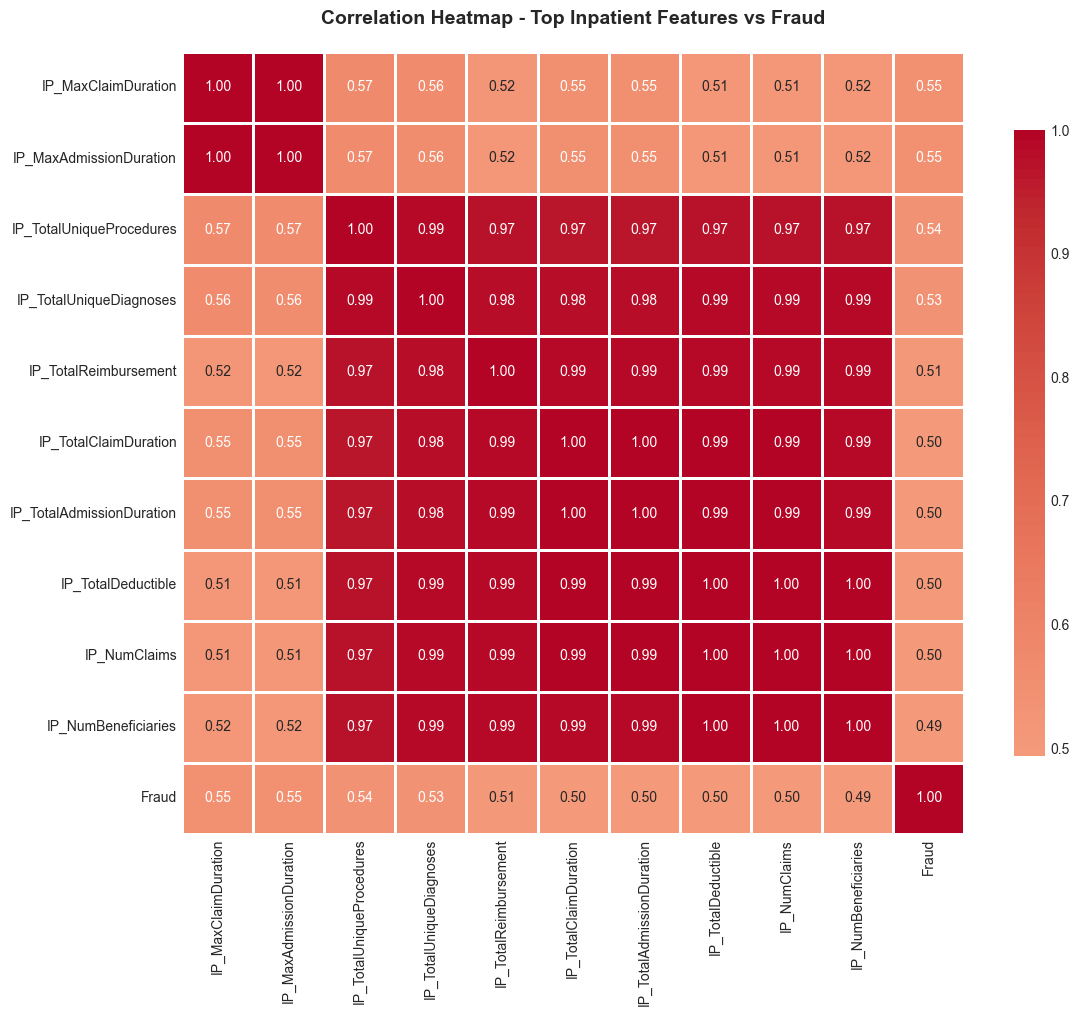

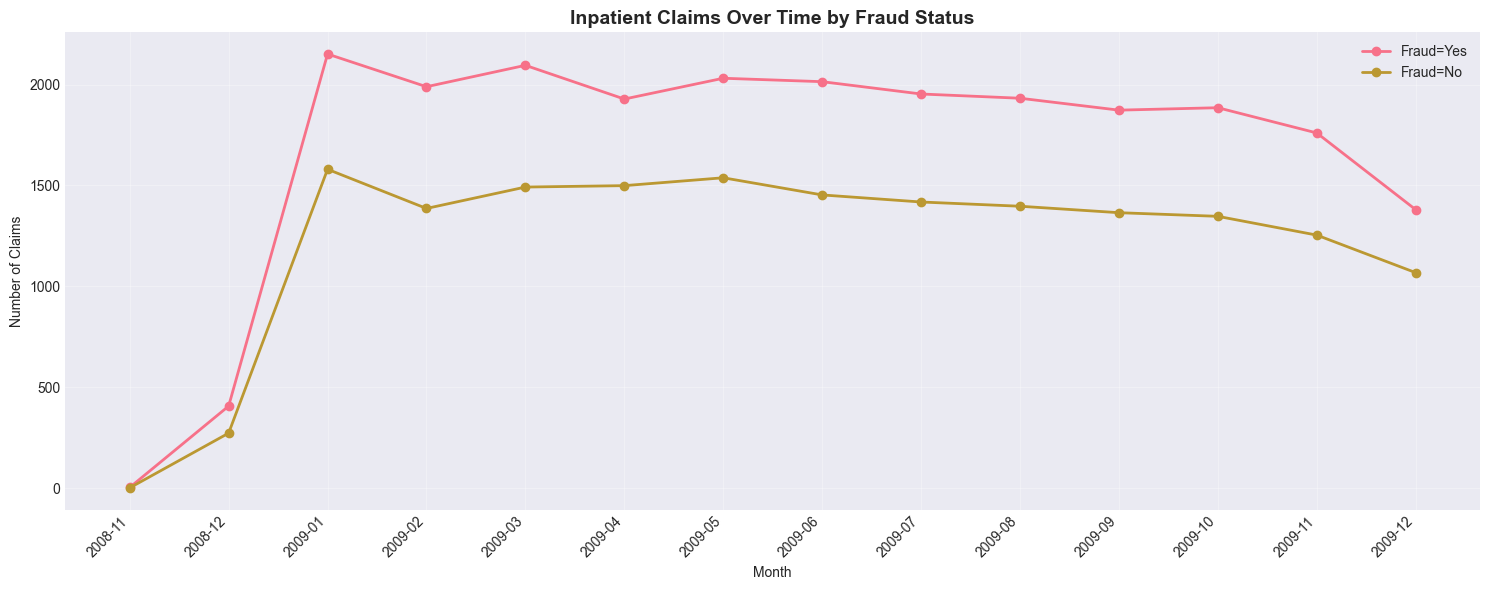

In [32]:
# First, DELETE cells 21-26 (the misplaced Section 13, 12, 11, 10 headers and code)
# They need to be removed and recreated in the correct order after Section 9

# Then ADD these cells in order after Section 9:

# ============================================================================
# Section 10: Fraud Analysis - Inpatient Features
# ============================================================================
# Merge with labels temporarily for fraud analysis (not saved to file)
provider_features_analysis = provider_inpatient.merge(labels_df, on='Provider', how='left')

# Basic fraud distribution
print('Provider dataset with labels:', provider_features_analysis.shape)
print(provider_features_analysis['PotentialFraud'].value_counts(dropna=False))

# Compare fraud vs non-fraud providers (mean values)
comparison_cols = [
    'IP_NumClaims', 'IP_NumBeneficiaries', 'IP_AvgReimbursement',
    'IP_TotalReimbursement', 'IP_ClaimsPerBeneficiary',
    'IP_AvgAdmissionDuration', 'IP_TotalUniqueDiagnoses'
]

comparison = provider_features_analysis.groupby('PotentialFraud')[comparison_cols].mean()
print('\nMean values by fraud status:')
print(comparison.T)

# Percentage difference (Yes vs No)
if set(['Yes','No']).issubset(comparison.index):
    pct_diff = ((comparison.loc['Yes'] - comparison.loc['No']) / comparison.loc['No'] * 100)
    print('\nPercentage Difference (Fraud vs Non-Fraud):')
    print(pct_diff.sort_values(ascending=False))

# Box plots for selected features
features_to_plot = ['IP_NumClaims', 'IP_TotalReimbursement', 'IP_ClaimsPerBeneficiary',
                    'IP_AvgReimbursement', 'IP_TotalUniqueDiagnoses', 'IP_AvgAdmissionDuration']

# Correlation with fraud (binary)
provider_features_analysis['Fraud'] = (provider_features_analysis['PotentialFraud'] == 'Yes').astype(int)
numeric_cols = provider_features_analysis.select_dtypes(include=[np.number]).columns.tolist()
if 'Fraud' in numeric_cols:
    numeric_cols.remove('Fraud')
correlations = provider_features_analysis[numeric_cols + ['Fraud']].corr()['Fraud'].sort_values(ascending=False)

print("Top 15 Features Correlated with Fraud:")
print(correlations[1:16])

# Correlation heatmap
top_features = correlations[1:11].index.tolist() + ['Fraud']
correlation_matrix = provider_features_analysis[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top Inpatient Features vs Fraud', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# Section 13: Temporal Patterns Analysis
# ============================================================================
# Claims over time by fraud status
inpatient_with_labels = inpatient_df.merge(labels_df[['Provider', 'PotentialFraud']], on='Provider', how='left')
inpatient_with_labels['YearMonth'] = inpatient_with_labels['ClaimStartDt'].dt.to_period('M')

temporal_summary = inpatient_with_labels.groupby(['YearMonth', 'PotentialFraud']).size().reset_index(name='NumClaims')
temporal_summary['YearMonth'] = temporal_summary['YearMonth'].astype(str)

# Plot
plt.figure(figsize=(15, 6))
for fraud_status in ['Yes', 'No']:
    data = temporal_summary[temporal_summary['PotentialFraud'] == fraud_status]
    plt.plot(data['YearMonth'], data['NumClaims'], marker='o', label=f'Fraud={fraud_status}', linewidth=2)

plt.title('Inpatient Claims Over Time by Fraud Status', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Claims')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Correlation Analysis with Fraud

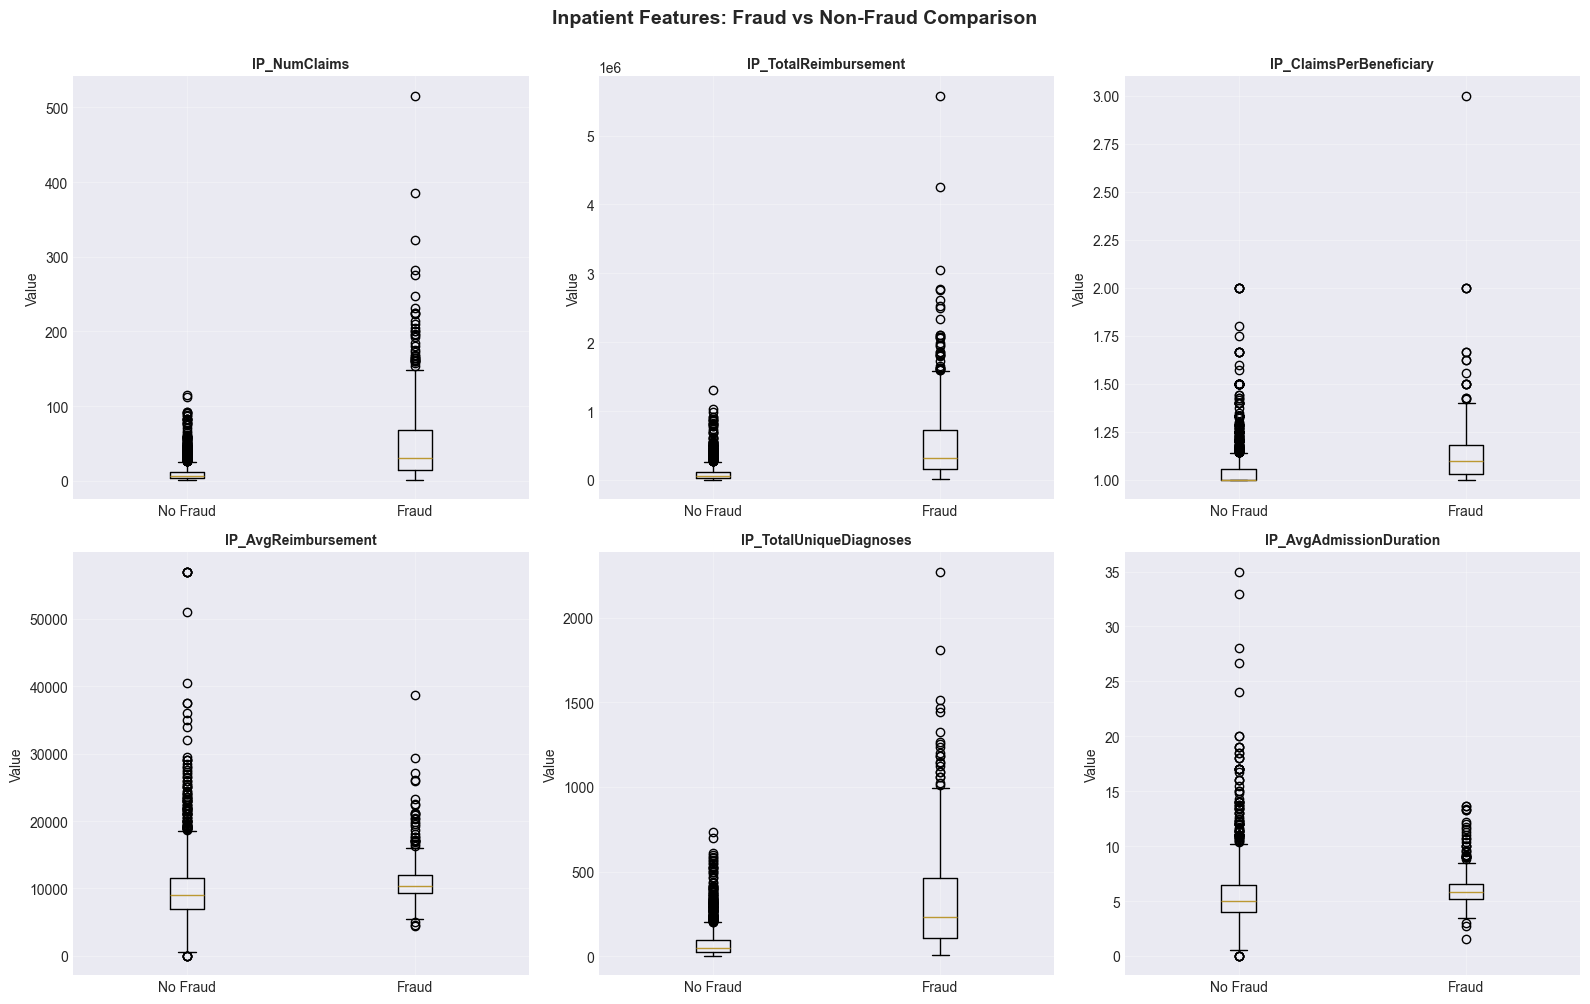

In [33]:
# Box plots comparing fraud vs non-fraud
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

features_to_plot = ['IP_NumClaims', 'IP_TotalReimbursement', 'IP_ClaimsPerBeneficiary',
                   'IP_AvgReimbursement', 'IP_TotalUniqueDiagnoses', 'IP_AvgAdmissionDuration']

for idx, feature in enumerate(features_to_plot):
    fraud_data = provider_features_analysis[provider_features_analysis['PotentialFraud'] == 'Yes'][feature].dropna()
    no_fraud_data = provider_features_analysis[provider_features_analysis['PotentialFraud'] == 'No'][feature].dropna()
    
    axes[idx].boxplot([no_fraud_data, fraud_data], labels=['No Fraud', 'Fraud'])
    axes[idx].set_title(f'{feature}', fontweight='bold', fontsize=10)
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Inpatient Features: Fraud vs Non-Fraud Comparison', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 13. Visualization - Fraud vs Non-Fraud Patterns

In [34]:
# Merge with labels temporarily for fraud analysis (not saved to file)
provider_features_analysis = provider_inpatient.merge(labels_df, on='Provider', how='left')

print(f"Provider dataset with labels for analysis: {provider_features_analysis.shape}")
print(f"\nFraud Distribution:")
print(provider_features_analysis['PotentialFraud'].value_counts())

comparison_cols = ['IP_NumClaims', 'IP_NumBeneficiaries', 'IP_AvgReimbursement', 
                   'IP_TotalReimbursement', 'IP_ClaimsPerBeneficiary',
                   'IP_AvgAdmissionDuration', 'IP_TotalUniqueDiagnoses']

comparison = provider_features_analysis.groupby('PotentialFraud')[comparison_cols].mean()
print("\nMean values by fraud status:")
print(comparison.T)

# Calculate percentage difference
pct_diff = ((comparison.loc['Yes'] - comparison.loc['No']) / comparison.loc['No'] * 100)
print("\nPercentage Difference (Fraud vs Non-Fraud):")
print(pct_diff.sort_values(ascending=False))

Provider dataset with labels for analysis: (2092, 29)

Fraud Distribution:
PotentialFraud
No     1652
Yes     440
Name: count, dtype: int64

Mean values by fraud status:
PotentialFraud                 No       Yes
IP_NumClaims                10.33     53.19
IP_NumBeneficiaries          9.68     46.87
IP_AvgReimbursement       9984.86  11046.24
IP_TotalReimbursement   101094.74 548382.98
IP_ClaimsPerBeneficiary      1.05      1.13
IP_AvgAdmissionDuration      5.55      6.11
IP_TotalUniqueDiagnoses     77.34    339.27

Percentage Difference (Fraud vs Non-Fraud):
IP_TotalReimbursement     442.44
IP_NumClaims              414.67
IP_NumBeneficiaries       384.15
IP_TotalUniqueDiagnoses   338.68
IP_AvgReimbursement        10.63
IP_AvgAdmissionDuration    10.23
IP_ClaimsPerBeneficiary     7.52
dtype: float64


## 14. Save Inpatient Provider Features

In [35]:
import os, datetime

def safe_to_csv(df, path):
    """Save DataFrame to CSV; if file locked, save with timestamp."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    try:
        df.to_csv(path, index=False)
        return path
    except PermissionError:
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        alt = path.replace(".csv", f"_{ts}.csv")
        df.to_csv(alt, index=False)
        return alt

# Save train and test inpatient provider features
train_path = '../data/processed/provider_inpatient_features.csv'
test_path  = '../data/processed/test_provider_inpatient_features.csv'

saved_train = safe_to_csv(provider_inpatient, train_path)
saved_test  = safe_to_csv(test_provider_inpatient, test_path)

print(f"✓ Saved train inpatient features: {saved_train}")
print(f"✓ Saved test inpatient features: {saved_test}")
print(f"\nInpatient Dataset Summary:")
print(f"  Providers: {provider_inpatient['Provider'].nunique()}")
print(f"  Features: {provider_inpatient.shape[1] - 1}")
print(f"  Columns: {list(provider_inpatient.columns)}")


✓ Saved train inpatient features: ../data/processed/provider_inpatient_features.csv
✓ Saved test inpatient features: ../data/processed/test_provider_inpatient_features.csv

Inpatient Dataset Summary:
  Providers: 2092
  Features: 26
  Columns: ['Provider', 'IP_NumClaims', 'IP_NumBeneficiaries', 'IP_AvgReimbursement', 'IP_TotalReimbursement', 'IP_MaxReimbursement', 'IP_StdReimbursement', 'IP_MedianReimbursement', 'IP_AvgDeductible', 'IP_TotalDeductible', 'IP_AvgClaimDuration', 'IP_TotalClaimDuration', 'IP_MaxClaimDuration', 'IP_StdClaimDuration', 'IP_AvgAdmissionDuration', 'IP_TotalAdmissionDuration', 'IP_MaxAdmissionDuration', 'IP_StdAdmissionDuration', 'IP_NumAttendingPhysicians', 'IP_NumOperatingPhysicians', 'IP_NumOtherPhysicians', 'IP_ClaimsPerBeneficiary', 'IP_ReimbursementPerDay', 'IP_ReimbursementPerBeneficiary', 'IP_TotalPhysicians', 'IP_TotalUniqueDiagnoses', 'IP_TotalUniqueProcedures']


## 15. Train and test outpatient aggregation and cleaning

In [36]:
import pandas as pd
import numpy as np
import os, datetime

# Helper function to save CSV safely
def safe_to_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    try:
        df.to_csv(path, index=False)
        return path, False
    except PermissionError:
        base, ext = os.path.splitext(path)
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        alt = f"{base}_{ts}{ext}"
        df.to_csv(alt, index=False)
        return alt, True

# =======================
# Function to process outpatient data
# =======================
def process_outpatient(df, name='Train'):
    # Convert dates and compute claim duration
    if 'ClaimStartDt' in df.columns and 'ClaimEndDt' in df.columns:
        df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'], errors='coerce')
        df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'], errors='coerce')
        df['ClaimDuration'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days

    # Aggregation dictionary
    agg_dict = {}
    if 'ClaimID' in df.columns: agg_dict['ClaimID'] = 'count'
    if 'BeneID' in df.columns: agg_dict['BeneID'] = 'nunique'
    if 'InscClaimAmtReimbursed' in df.columns: agg_dict['InscClaimAmtReimbursed'] = ['mean','sum','max','std','median']
    if 'DeductibleAmtPaid' in df.columns: agg_dict['DeductibleAmtPaid'] = ['mean','sum']
    if 'ClaimDuration' in df.columns: agg_dict['ClaimDuration'] = ['mean','sum','max','std']
    for phys in ['AttendingPhysician','OperatingPhysician','OtherPhysician']:
        if phys in df.columns: agg_dict[phys] = 'nunique'

    # Group by Provider
    provider_df = df.groupby('Provider').agg(agg_dict).reset_index()

    # Flatten multi-index columns
    new_cols = ['Provider']
    for col in provider_df.columns[1:]:
        base, func = col if isinstance(col, tuple) else (col, '')
        if base == 'ClaimID' and func == 'count': name_col = 'OP_NumClaims'
        elif base == 'BeneID' and func == 'nunique': name_col = 'OP_NumBeneficiaries'
        elif base == 'InscClaimAmtReimbursed':
            mapping = {'mean':'OP_AvgReimbursement','sum':'OP_TotalReimbursement','max':'OP_MaxReimbursement',
                       'std':'OP_StdReimbursement','median':'OP_MedianReimbursement'}
            name_col = mapping.get(func, f'OP_Reimbursement_{func}')
        elif base == 'DeductibleAmtPaid':
            mapping = {'mean':'OP_AvgDeductible','sum':'OP_TotalDeductible'}
            name_col = mapping.get(func, f'OP_Deductible_{func}')
        elif base == 'ClaimDuration':
            mapping = {'mean':'OP_AvgClaimDuration','sum':'OP_TotalClaimDuration','max':'OP_MaxClaimDuration','std':'OP_StdClaimDuration'}
            name_col = mapping.get(func, f'OP_ClaimDuration_{func}')
        elif base in ['AttendingPhysician','OperatingPhysician','OtherPhysician'] and func=='nunique':
            mapping = {'AttendingPhysician':'OP_NumAttendingPhysicians','OperatingPhysician':'OP_NumOperatingPhysicians','OtherPhysician':'OP_NumOtherPhysicians'}
            name_col = mapping.get(base, f'OP_{base}_nunique')
        else:
            name_col = f'OP_{base}_{func}' if func else f'OP_{base}'
        new_cols.append(name_col)
    provider_df.columns = new_cols

    # Fill missing std values
    for std_col in ['OP_StdReimbursement','OP_StdClaimDuration']:
        if std_col in provider_df.columns: provider_df[std_col] = provider_df[std_col].fillna(0)

    # Derived features
    if 'OP_NumClaims' in provider_df.columns and 'OP_NumBeneficiaries' in provider_df.columns:
        provider_df['OP_ClaimsPerBeneficiary'] = provider_df['OP_NumClaims'] / provider_df['OP_NumBeneficiaries'].replace(0,np.nan)
    if 'OP_TotalReimbursement' in provider_df.columns and 'OP_TotalClaimDuration' in provider_df.columns:
        provider_df['OP_ReimbursementPerDay'] = provider_df['OP_TotalReimbursement'] / provider_df['OP_TotalClaimDuration'].replace(0,np.nan)
    if 'OP_TotalReimbursement' in provider_df.columns and 'OP_NumBeneficiaries' in provider_df.columns:
        provider_df['OP_ReimbursementPerBeneficiary'] = provider_df['OP_TotalReimbursement'] / provider_df['OP_NumBeneficiaries'].replace(0,np.nan)

    print(f"{name} Outpatient dataset: providers={provider_df['Provider'].nunique()}, features={provider_df.shape[1]-1}")
    return provider_df

# =======================
# Process Train
# =======================
provider_outpatient = process_outpatient(outpatient_df, name='Train')

# =======================
# Process Test (if available)
# =======================
if 'test_outpatient_df' in globals():
    test_provider_outpatient = process_outpatient(test_outpatient_df, name='Test')


Train Outpatient dataset: providers=5012, features=19
Test Outpatient dataset: providers=1259, features=19


## 16. Save Outpatient Provider Features

In [37]:
# =======================
# Add outpatient diagnosis and procedure features
# =======================

def add_diag_proc_features(df, source_df, name='Train'):
    diag_cols = [col for col in source_df.columns if 'ClmDiagnosisCode' in col]
    proc_cols = [col for col in source_df.columns if 'ClmProcedureCode' in col]

    # Diagnosis
    if diag_cols:
        diag_features = source_df.groupby('Provider')[diag_cols].apply(
            lambda x: x.apply(lambda col: col.dropna().nunique())
        ).reset_index()
        diag_features['OP_TotalUniqueDiagnoses'] = diag_features[diag_cols].sum(axis=1)
        diag_features = diag_features[['Provider', 'OP_TotalUniqueDiagnoses']]
    else:
        diag_features = pd.DataFrame({'Provider': source_df['Provider'].unique(), 'OP_TotalUniqueDiagnoses': 0})

    # Procedure
    if proc_cols:
        proc_features = source_df.groupby('Provider')[proc_cols].apply(
            lambda x: x.apply(lambda col: col.dropna().nunique())
        ).reset_index()
        proc_features['OP_TotalUniqueProcedures'] = proc_features[proc_cols].sum(axis=1)
        proc_features = proc_features[['Provider', 'OP_TotalUniqueProcedures']]
    else:
        proc_features = pd.DataFrame({'Provider': source_df['Provider'].unique(), 'OP_TotalUniqueProcedures': 0})

    # Merge
    df = df.merge(diag_features, on='Provider', how='left')
    df = df.merge(proc_features, on='Provider', how='left')

    print(f"✓ Added outpatient diagnosis and procedure features ({name})")
    print(df[['Provider', 'OP_TotalUniqueDiagnoses', 'OP_TotalUniqueProcedures']].head(6))
    return df

# =======================
# Train
# =======================
provider_outpatient = add_diag_proc_features(provider_outpatient, outpatient_df, name='Train')

# =======================
# Test (if available)
# =======================
if 'test_outpatient_df' in globals() and 'test_provider_outpatient' in globals():
    test_provider_outpatient = add_diag_proc_features(test_provider_outpatient, test_outpatient_df, name='Test')

# =======================
# Save final CSV files
# =======================
train_csv_path = '../data/processed/provider_outpatient_features.csv'
saved_train_path, _ = safe_to_csv(provider_outpatient, train_csv_path)
print(f"Saved train outpatient CSV: {saved_train_path}")

if 'test_provider_outpatient' in globals():
    test_csv_path = '../data/processed/test_provider_outpatient_features.csv'
    saved_test_path, _ = safe_to_csv(test_provider_outpatient, test_csv_path)
    print(f"Saved test outpatient CSV: {saved_test_path}")


✓ Added outpatient diagnosis and procedure features (Train)
   Provider  OP_TotalUniqueDiagnoses  OP_TotalUniqueProcedures
0  PRV51001                       43                         0
1  PRV51003                      163                         0
2  PRV51004                      332                         0
3  PRV51005                     1873                         0
4  PRV51007                      180                         0
5  PRV51008                      108                         0
✓ Added outpatient diagnosis and procedure features (Test)
   Provider  OP_TotalUniqueDiagnoses  OP_TotalUniqueProcedures
0  PRV51002                      457                         0
1  PRV51006                      245                         0
2  PRV51009                       94                         0
3  PRV51010                       72                         0
4  PRV51018                      431                         0
5  PRV51019                       11                         0

## 17. Provider-Level Aggregation - Outpatient Claims

In [38]:
# Convert dates for outpatient
op_date_cols = ['ClaimStartDt', 'ClaimEndDt']
for col in op_date_cols:
    if col in outpatient_df.columns:
        outpatient_df[col] = pd.to_datetime(outpatient_df[col], errors='coerce')

# Temporal features (no admissions for outpatient)
outpatient_df['ClaimDuration'] = (outpatient_df['ClaimEndDt'] - outpatient_df['ClaimStartDt']).dt.days
outpatient_df['ClaimMonth'] = outpatient_df['ClaimStartDt'].dt.month
outpatient_df['ClaimYear'] = outpatient_df['ClaimStartDt'].dt.year
outpatient_df['ClaimDayOfWeek'] = outpatient_df['ClaimStartDt'].dt.dayofweek

print("✓ Outpatient temporal features created")
print("\nOP Date Range:")
print(f"Claim Start: {outpatient_df['ClaimStartDt'].min()} to {outpatient_df['ClaimStartDt'].max()}")
print("\nOP Claim Duration Statistics:")
print(outpatient_df['ClaimDuration'].describe())

✓ Outpatient temporal features created

OP Date Range:
Claim Start: 2008-12-12 00:00:00 to 2009-12-31 00:00:00

OP Claim Duration Statistics:
count   517737.00
mean         1.42
std          4.71
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         23.00
Name: ClaimDuration, dtype: float64


In [39]:
# Check data quality
print("\n2. Data quality checks...")
print(f"Train IP claims: {len(inpatient_df)}, unique providers: {inpatient_df['Provider'].nunique()}")
print(f"Train OP claims: {len(outpatient_df)}, unique providers: {outpatient_df['Provider'].nunique()}")
print(f"Test IP claims: {len(test_inpatient_df)}, unique providers: {test_inpatient_df['Provider'].nunique()}")
print(f"Test OP claims: {len(test_outpatient_df)}, unique providers: {test_outpatient_df['Provider'].nunique()}")

print("\n✓ Data cleaning completed!")


2. Data quality checks...
Train IP claims: 40474, unique providers: 2092
Train OP claims: 517737, unique providers: 5012
Test IP claims: 9551, unique providers: 520
Test OP claims: 125841, unique providers: 1259

✓ Data cleaning completed!


In [40]:
# Merge inpatient and outpatient features
print("\n1. Merging inpatient and outpatient features...")

train_provider_features = provider_inpatient.merge(provider_outpatient, on='Provider', how='outer').fillna(0)
test_provider_features = test_provider_inpatient.merge(test_provider_outpatient, on='Provider', how='outer').fillna(0)

print(f"Train merged: {train_provider_features.shape}")
print(f"Test merged: {test_provider_features.shape}")

# Create final datasets with labels
print("\n2. Creating final model-ready datasets...")

# Training data with labels
train_final = train_provider_features.merge(labels_df[['Provider', 'PotentialFraud']], on='Provider', how='inner')
train_final['PotentialFraud'] = (train_final['PotentialFraud'] == 'Yes').astype(int)

# Test data (no labels)
test_final = test_provider_features.copy()

print(f"Training dataset: {train_final.shape}, Fraud rate: {train_final['PotentialFraud'].mean():.1%}")
print(f"Test dataset: {test_final.shape}")

# Save final datasets
print("\n3. Saving final datasets...")

train_final.to_csv('../data/processed/train_final.csv', index=False)
test_final.to_csv('../data/processed/test_final.csv', index=False)

print("Final datasets saved!")
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Training data: {train_final.shape[0]} providers, {train_final.shape[1]-2} features")
print(f"Test data: {test_final.shape[0]} providers, {test_final.shape[1]-1} features")
print("Ready for modeling!")


1. Merging inpatient and outpatient features...
Train merged: (5410, 48)
Test merged: (1353, 48)

2. Creating final model-ready datasets...
Training dataset: (5410, 49), Fraud rate: 9.4%
Test dataset: (1353, 48)

3. Saving final datasets...
Final datasets saved!

SUMMARY
Training data: 5410 providers, 47 features
Test data: 1353 providers, 47 features
Ready for modeling!
